In [1]:
__author__ = 'Erwin Chen'
%matplotlib inline
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from astropy.io import fits
from astropy.table import Table, join, Column
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors, DistanceMetric
from sklearn import mixture, preprocessing
from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial.distance as distance
from sklearn.metrics.cluster import v_measure_score, homogeneity_completeness_v_measure
import cPickle as pickle

In [2]:
# load data
ap_table_nn = Table.read("ap_table_halo_nn.csv")
S = pickle.load(open('SNN_distance_matrix.p', 'rb'))
labels = pickle.load(open('SNN_DBSCAN_labels.p', 'rb'))
true_labels = ap_table_nn['label']
n_clumps = np.amax(labels)+1

In [3]:
# browse table
ap_table_nn

APOGEE_ID,GLON,GLAT,RA,DEC,VHELIO_AVG,LOGG,TEFF,PMRA,PMDEC,AL_H,NA_H,O_H,MG_H,C_H,N_H,V_H,TI_H,CA_H,FE_H,K_H,MN_H,NI_H,SI_H,S_H,SNR,cluster_name,label
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,int32
2M00000233+1452324,104.845530012,-46.1831575822,0.009748,14.875667,-38.9021987915,4.03070009949,4865.38359062,-34.0,-54.0,0.261829540594,0.47062336064,0.393294031647,0.348053102055,0.253629152434,0.493272177223,0.796181523204,0.396065871903,0.215283788896,0.356053296874,0.0243365520877,0.569467547459,0.359815384901,0.373881336837,0.257360320635,264.618011475,background,-1
2M00000535+1504343,104.94478517,-45.9944082719,0.022311,15.07621,18.4577007294,3.22492511536,4918.64992707,19.2999992371,-1.29999995232,0.11100670928,-0.0744779302855,0.027749336848,0.0168333062754,0.015845271334,-0.00477599233739,-0.399830086563,0.0746334183107,-0.03632512435,-0.018976405582,-0.120571039875,0.0534394196768,-0.137308158381,0.0577027637586,0.0811246753667,177.406005859,background,-1
2M00000662+7528598,119.657400871,12.9390126032,0.02762200393,75.4832923522,10.7636995316,3.27840103718,5552.72568446,34.0999984741,5.19999980927,-1.04378163946,-0.738582889791,-0.876771465592,-0.80040793816,-0.597634773514,-0.902891085681,-0.72459356224,-0.924094560501,-0.992758315541,-1.02624946202,-1.09844624665,-0.950526826431,-0.896189224894,-0.911157539153,-0.705795168857,459.343994141,background,-1
2M00001616+1606151,105.417428215,-45.0202621766,0.067374,16.104208,-52.6385993958,2.99123018302,4790.41806358,0.0,0.0,0.452043876978,0.500474939817,0.388844209571,0.232870669436,0.159224078379,0.391354453939,-0.0637129773501,0.224256339297,0.101248298833,0.179218489571,-0.0806760760838,0.245180401863,0.243309292081,0.438587502976,0.101725109547,88.0950012207,background,-1
2M00002141+8606336,121.996034171,23.3309377904,0.089231,86.10936,-80.4522018433,3.24167290869,4843.60108183,0.0,0.0,0.180633131183,-0.250728477278,0.122229091206,0.12544614216,0.0857932487254,0.109029767801,-0.342852845943,0.12757715784,0.0912187645794,0.0702222843662,-0.0441944203795,0.150547624703,0.0781657787366,0.141291066546,0.209995111718,145.419006348,background,-1
2M00002504+1517108,105.139477988,-45.815317608,0.10437,15.286342,-60.9762992859,2.15802496247,4499.50911484,-2.5,-13.6000003815,-0.220732703105,-0.937452976794,-0.298345233122,-0.423187741566,-0.485510002787,-0.368285823825,-0.87628562313,-0.563476395517,-0.447198832607,-0.470219753774,-0.518283674211,-0.493527238463,-0.513280779655,-0.146117665263,-0.193660950215,323.42300415,background,-1
2M00003119+1516179,105.167584095,-45.8363642727,0.129997,15.271665,-19.9004001617,2.64911657193,4904.06383307,-8.30000019073,-3.90000009537,-0.152893756509,-0.445188126265,-0.27035654191,-0.321348676192,-0.409137956894,-0.36055806523,-0.345648425566,-0.457487364939,-0.414481703726,-0.370274340583,-0.430150268834,-0.362091379051,-0.372004312907,-0.0593802824179,-0.188840705277,631.614990234,background,-1
2M00003151+1556005,105.433657899,-45.2013542493,0.131297,15.933473,-16.341299057,2.19499216512,4661.97017012,2.0,0.0,-0.186815698,-0.314585074156,-0.235437366674,-0.416012284344,-0.466061331772,-0.239800310231,-0.478225271918,-0.337276441826,-0.455068002362,-0.407466147874,-0.77266826731,-0.453097421169,-0.487471501892,-0.0984874024869,-0.310457879136,229.268997192,background,-1
2M00003240+1707161,105.898336498,-44.0606141968,0.135019,17.121164,-53.8454017639,2.78425659518,4588.74110451,-4.0,-10.0,0.45700967078,0.379952910752,0.422772232419,0.343535351237,0.337692433119,0.577155271349,0.349995423556,0.470234646238,0.211095295642,0.308791206988,0.172191218026,0.583947824088,0.338654857339,0.428249669048,0.409738572359,444.470001221,background,-1


In [4]:
# %%time 

# # DBSCAN
# db = DBSCAN(eps=0.35, min_samples=8, metric='precomputed', n_jobs=-1).fit(S, lengths[non_noise])
# labels = db.labels_

In [5]:
# get globular cluster members
globular_names = np.array(['M107', 'M53', 'M92', 'M5', 'M13', 'M3', 'M2', 'M15', 'N5466'])
globular_members = np.array([], dtype='int')
globular_labels = np.array([], dtype='int')
for name in globular_names:
    cluster_members = np.where(ap_table_nn['cluster_name'] == name)[0]
    label = ap_table_nn['label'][cluster_members][0]
    globular_members = np.append(globular_members, cluster_members)
    globular_labels = np.append(globular_labels, label)
    print "%s has %i members"%(name, len(cluster_members))
print "%i members in total"%len(globular_members)

M107 has 17 members
M53 has 16 members
M92 has 48 members
M5 has 103 members
M13 has 71 members
M3 has 72 members
M2 has 8 members
M15 has 11 members
N5466 has 8 members
354 members in total


In [6]:
# get recovered members
recovered = np.where([])
for n in range(n_clumps):
    group = np.where(labels == n)[0]
    group_labels = true_labels[group]
    members_in_group = np.where(group_labels != -1)[0]
    numbers = list(set(group_labels[members_in_group]))
    for num in numbers:
        len_cluster = len(np.where(group_labels[members_in_group] == num)[0])
        len_clusters = len(members_in_group)
        if (len_cluster >= len_clusters) and (len_cluster > len(group)*0.15):
            recovered = np.append(recovered, group[np.where(group_labels == num)[0]])
recovered = np.intersect1d(recovered, globular_members)
print "%i known members recovered"%len(recovered)

145 known members recovered


In [7]:
# load chemical abundances
NA = ap_table_nn['NA_H']-ap_table_nn['FE_H']
O = ap_table_nn['O_H']-ap_table_nn['FE_H']
MG = ap_table_nn['MG_H']-ap_table_nn['FE_H']
AL = ap_table_nn['AL_H']-ap_table_nn['FE_H']
SI = ap_table_nn["SI_H"] - ap_table_nn["FE_H"]
C = ap_table_nn["C_H"] - ap_table_nn["FE_H"]
N = ap_table_nn["N_H"] - ap_table_nn["FE_H"]
CA = ap_table_nn["CA_H"] - ap_table_nn["FE_H"]
RV = ap_table_nn['VHELIO_AVG']
GLON = ap_table_nn['GLON']
GLAT = ap_table_nn['GLAT']
LOGG = ap_table_nn['LOGG']
TEFF = ap_table_nn['TEFF']
RA = ap_table_nn['RA']
DEC = ap_table_nn['DEC']

In [8]:
# plotting variables
num_g_c = len(list(set(globular_labels)))
colors = np.linspace(0, 1, num_g_c)
cm = plt.get_cmap('rainbow')

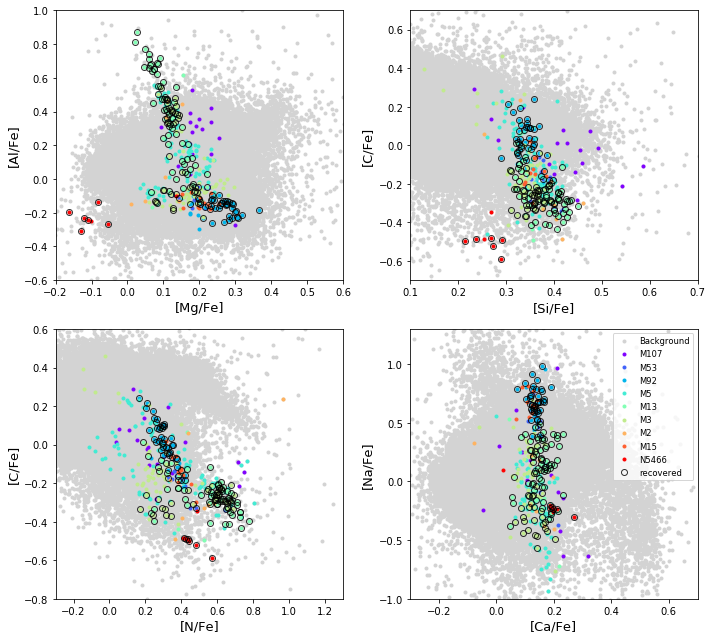

In [9]:
# plot recovered members
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))

X = MG
Y = AL
xlab = "[Mg/Fe]"
ylab = "[Al/Fe]"
axes[0, 0].plot(X, Y, '.', c='lightgrey', label='Background')
for i in range(len(globular_names)):
    name = globular_names[i]
    members = np.where(ap_table_nn["cluster_name"] == name)[0]
    axes[0, 0].plot(X[members], Y[members], '.', c=cm(colors[i]), label=name)
axes[0, 0].plot(X[recovered], Y[recovered], 'o', c='k', label='recovered', alpha=0.8, markerfacecolor='None')
axes[0, 0].set_xlim(-0.2, 0.6)
axes[0, 0].set_ylim(-0.6, 1)
axes[0, 0].set_xlabel(xlab, fontsize=13)
axes[0, 0].set_ylabel(ylab, fontsize=13)

X = SI
Y = C
xlab = "[Si/Fe]"
ylab = "[C/Fe]"
axes[0, 1].plot(X, Y, '.', c='lightgrey', label='Background')
for i in range(len(globular_names)):
    name = globular_names[i]
    members = np.where(ap_table_nn["cluster_name"] == name)[0]
    axes[0, 1].plot(X[members], Y[members], '.', c=cm(colors[i]), label=name)
axes[0, 1].plot(X[recovered], Y[recovered], 'o', c='k', label='recovered', alpha=0.8, markerfacecolor='None')
axes[0, 1].set_xlim(0.1, 0.7)
axes[0, 1].set_ylim(-0.7, 0.7)
axes[0, 1].set_xlabel(xlab, fontsize=13)
axes[0, 1].set_ylabel(ylab, fontsize=13)

X = N
Y = C
xlab = "[N/Fe]"
ylab = "[C/Fe]"
axes[1, 0].plot(X, Y, '.', c='lightgrey', label='Background')
for i in range(len(globular_names)):
    name = globular_names[i]
    members = np.where(ap_table_nn["cluster_name"] == name)[0]
    axes[1, 0].plot(X[members], Y[members], '.', c=cm(colors[i]), label=name)
axes[1, 0].plot(X[recovered], Y[recovered], 'o', c='k', label='recovered', alpha=0.8, markerfacecolor='None')
axes[1, 0].set_xlim(-0.3, 1.3)
axes[1, 0].set_ylim(-0.8, 0.6)
axes[1, 0].set_xlabel(xlab, fontsize=13)
axes[1, 0].set_ylabel(ylab, fontsize=13)

X = CA
Y = NA
xlab = "[Ca/Fe]"
ylab = "[Na/Fe]"
axes[1, 1].plot(X, Y, '.', c='lightgrey', label='Background')
for i in range(len(globular_names)):
    name = globular_names[i]
    members = np.where(ap_table_nn["cluster_name"] == name)[0]
    axes[1, 1].plot(X[members], Y[members], '.', c=cm(colors[i]), label=name)
axes[1, 1].plot(X[recovered], Y[recovered], 'o', c='k', label='recovered', alpha=0.8, markerfacecolor='None')
axes[1, 1].set_xlim(-0.3, 0.7)
axes[1, 1].set_ylim(-1, 1.3)
axes[1, 1].set_xlabel(xlab, fontsize=13)
axes[1, 1].set_ylabel(ylab, fontsize=13)
axes[1, 1].legend(loc= "upper right", fontsize="small")

# plt.legend(loc='upper right', bbox_to_anchor=(1.17,0.7), bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
# plt.savefig("ISNN_halo.png", dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# get DBSCAN groups more than 5 stars
plot_labels = []
for n in range(max(labels)+1):
    group = np.where(labels == n)[0]
    members_in_group = np.intersect1d(globular_members, group)
    if len(members_in_group) > 5:
        plot_labels.append(n)

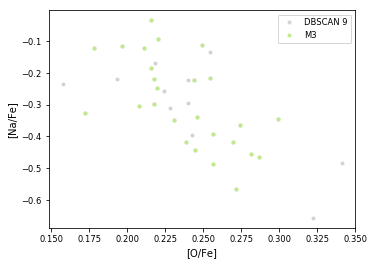

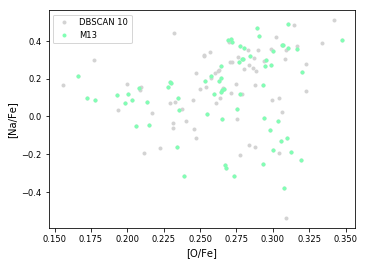

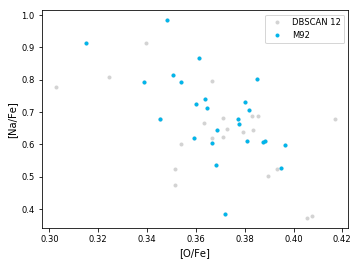

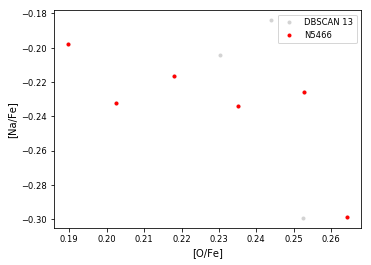

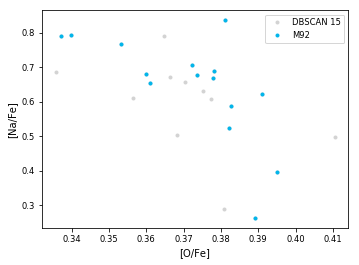

In [11]:
# plot Na against O
X = O
Y = NA
xlab = "[O/Fe]"
ylab = "[Na/Fe]"
for n in plot_labels:
    group = np.where(labels == n)[0]
    fig = plt.figure(figsize=(5.5, 4))
    plt.plot(X[group], Y[group], ".", c="lightgrey", label="DBSCAN %i"%n)
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_nn["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            plt.plot(X[group_members], Y[group_members], ".", c=cm(colors[i]), label=name)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.legend(loc=0, fontsize="small")
#     plt.savefig("Cannon/SNN_%i_O_NA.png"%n, dpi=150)
    plt.show()

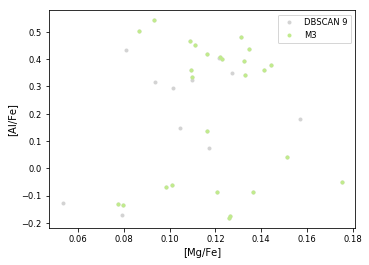

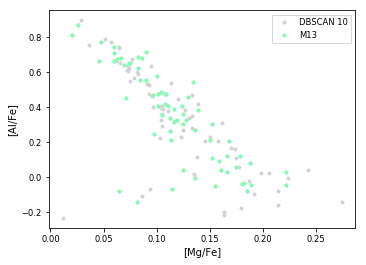

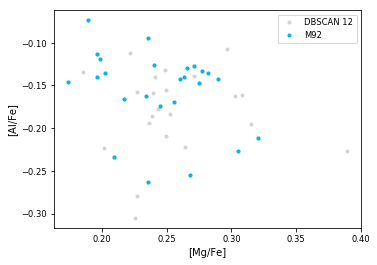

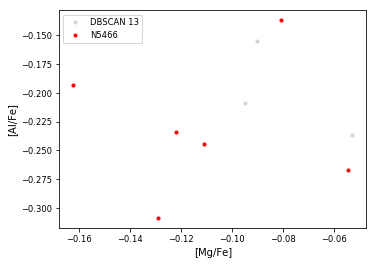

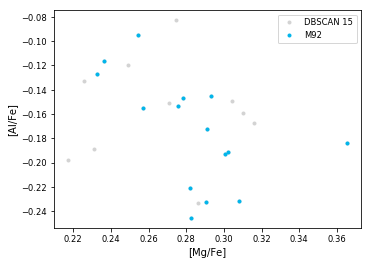

In [12]:
# plot Al against Mg
X = MG
Y = AL
xlab = "[Mg/Fe]"
ylab = "[Al/Fe]"
for n in plot_labels:
    group = np.where(labels == n)[0]
    fig = plt.figure(figsize=(5.5, 4))
    plt.plot(X[group], Y[group], ".", c="lightgrey", label="DBSCAN %i"%n)
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_nn["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            plt.plot(X[group_members], Y[group_members], ".", c=cm(colors[i]), label=name)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.legend(loc=0, fontsize="small")
#     plt.savefig("Cannon/SNN_%i_MG_AL.png"%n, dpi=150)
    plt.show()

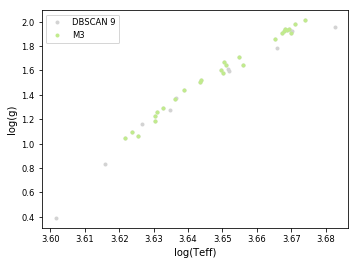

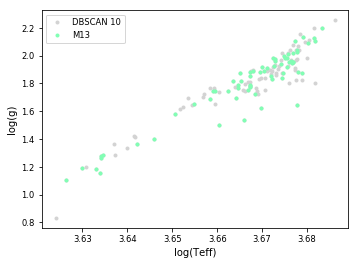

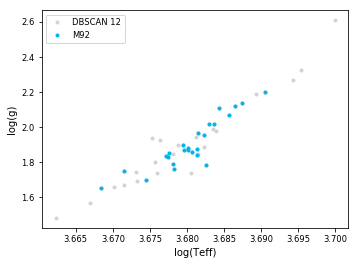

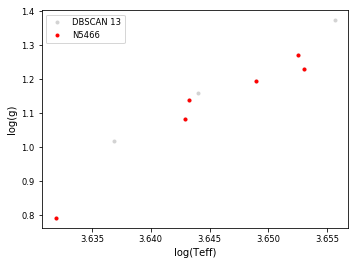

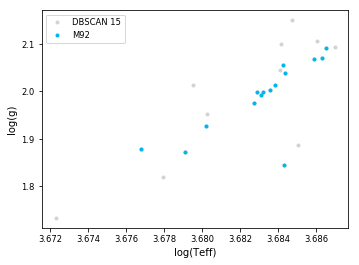

In [13]:
# plot log(g) against log(Teff)
xlab = "log(Teff)"
ylab = "log(g)"
X = np.array([np.log10(x) for x in TEFF])
Y = LOGG
for n in plot_labels:
    group = np.where(labels == n)[0]
    fig = plt.figure(figsize=(5.5, 4))
    plt.plot(X[group], Y[group], ".", c="lightgrey", label="DBSCAN %i"%n)
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_nn["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            plt.plot(X[group_members], Y[group_members], ".", c=cm(colors[i]), label=name)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.legend(loc=0, fontsize="small")
#     plt.savefig("Cannon/SNN_%i_Teff_logg.png"%n, dpi=150)
    plt.show()

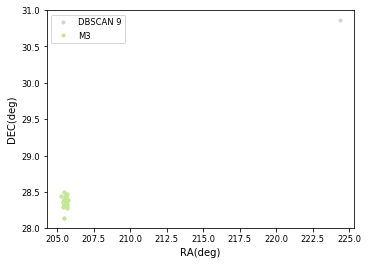

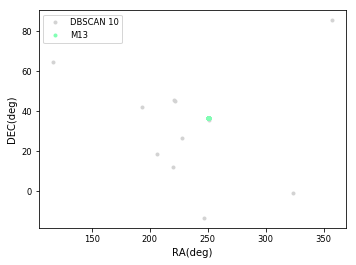

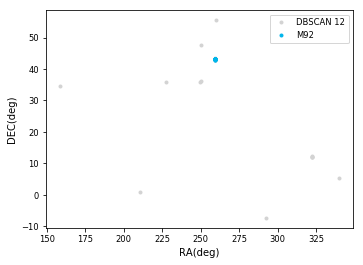

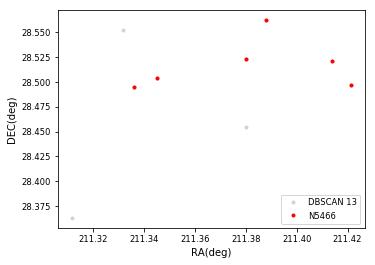

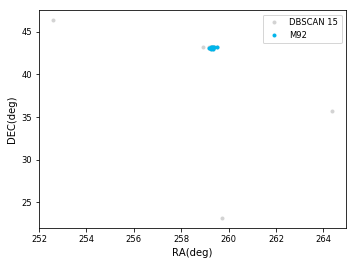

In [14]:
# plot DEC against RA
xlab = "RA(deg)"
ylab = "DEC(deg)"
X = RA
Y = DEC
for n in plot_labels:
    group = np.where(labels == n)[0]
    fig = plt.figure(figsize=(5.5, 4))
    plt.plot(X[group], Y[group], ".", c="lightgrey", label="DBSCAN %i"%n)
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_nn["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            plt.plot(X[group_members], Y[group_members], ".", c=cm(colors[i]), label=name)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.legend(loc=0, fontsize="small")
#     plt.savefig("Cannon/SNN_%i_RA_DEC.png"%n, dpi=150)
    plt.show()

In [15]:
# load tidal radius data
recover_names = np.array(["M92", "M5", "M13", "M3", "N5466"])
tidal_radius = np.array([14.850, 29.652, 27.195, 35.397, 52.754])
center_RA = np.array([259.28042, 229.64083, 250.42292, 205.54667, 211.3625])
center_DEC = np.array([43.13639, 2.08278, 36.46028, 28.37556, 28.5344])
names = ["cluster_name", "tidal_radius", "RA", "DEC"]
dtype = ["string", "float", "float", "float"]
tidal_table = Table([recover_names, tidal_radius, center_RA, center_DEC], names=names, dtype=dtype)

In [16]:
def rad(degree):
    return degree * np.pi / 180.

def ang_distance(RA1, RA2, DEC1, DEC2):
    cos_d = np.sin(rad(DEC1)) * np.sin(rad(DEC2)) + np.cos(rad(DEC1)) * np.cos(rad(DEC2)) * np.cos(rad(RA1 - RA2))
    d = np.arccos(cos_d) * 180. / np.pi
    return d*60

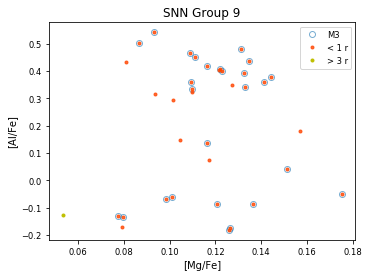

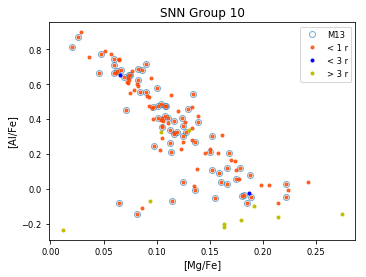

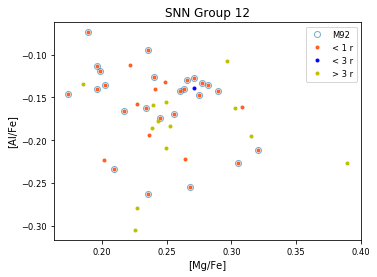

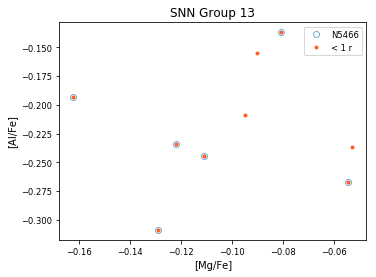

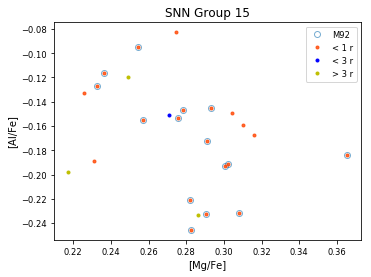

In [17]:
# plot tidal radius
xlab = "[Mg/Fe]"
ylab = "[Al/Fe]"
X = MG
Y = AL
for n in plot_labels:
    group = np.where(labels == n)[0]
    fig = plt.figure(figsize=(5.5, 4))
    for i in range(len(globular_names)):
        name = globular_names[i]
        members = np.where(ap_table_nn["cluster_name"] == name)[0]
        group_members = np.intersect1d(members, group)
        if len(group_members) > 0:
            tidal_index = np.where(tidal_table["cluster_name"] == name)[0]
            group_RA = RA[group]
            group_DEC = DEC[group]
            center_RA = tidal_table["RA"][tidal_index]
            center_DEC = tidal_table["DEC"][tidal_index]
            tidal_radius = tidal_table["tidal_radius"][tidal_index]
            angular_dist = ang_distance(group_RA, center_RA, group_DEC, center_DEC) 
#             print [x for x in angular_dist / tidal_radius if x > 1]
            rad_1 = np.where(angular_dist <= tidal_radius)[0]
            rad_2 = np.where((angular_dist > tidal_radius) * (angular_dist <= 3.0*tidal_radius))[0]
            rad_3 = np.where(angular_dist > 3.0 *tidal_radius)[0]
            rad_1 = group[rad_1]
            rad_2 = group[rad_2]
            rad_3 = group[rad_3]
            plt.plot(X[group_members], Y[group_members], "o", label=name, alpha=0.6, markerfacecolor='None')
            plt.plot(X[rad_1], Y[rad_1], ".", c='orangered', label='< 1 r', alpha = 0.8)
            if len(rad_2) > 0:
                plt.plot(X[rad_2], Y[rad_2], ".", c='b', label='< 3 r')
            if len(rad_3) > 0:
                plt.plot(X[rad_3], Y[rad_3], ".", c='y', label='> 3 r')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(fontsize="small")
    plt.yticks(fontsize="small")
    plt.legend(loc=0, fontsize="small", numpoints=1)
    plt.title("SNN Group %i"%n)
#     plt.savefig("Cannon/SNN/SNN_%i_tidal_radius.png"%n, dpi=150)
    plt.show()